In [1]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 390 (delta 89), reused 53 (delta 51), pack-reused 269
Receiving objects: 100% (390/390), 107.16 KiB | 21.43 MiB/s, done.
Resolving deltas: 100% (191/191), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.5 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a NVIDIA A100-SXM4-40GB!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.5/502.5 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 9.8 MB/s eta 0:00:00


In [3]:
import cudf
import shap
import cuml
import plotly
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from cuml import LinearRegression
from cuml.metrics import r2_score
from cuml.metrics.regression import mean_squared_error
from cuml import ElasticNet
from cuml import PCA
from sklearn.model_selection import GridSearchCV
from google.colab import drive

import warnings
# ignore all warnings
warnings.filterwarnings('ignore')

In [5]:
drive.mount("./drive")

Mounted at ./drive


In [ ]:
pwd

'/content'

In [6]:
# load data
data = cudf.read_csv("/content//drive//MyDrive//datashare//GKX_20201231.csv").dropna()

In [48]:
# split data
data = data[(data['DATE']>=19850131) & (data['DATE']<=20181231)]
data['year'] = data['DATE'].apply(lambda x: x//1e4)
data['yyyymm'] = data['DATE'].apply(lambda x: x//100)
year_data = data.groupby(['permno','year']).mean().reset_index().drop(['DATE'],axis=1)

In [114]:
# load MacroeconomicPredictors
macro_char = cudf.read_csv("/content/drive/MyDrive/datashare/MacroeconomicPredictors.csv",index_col = 0)
macro_char = macro_char[macro_char['yyyymm']>=195701]
monthly_ret_df = data.groupby(['yyyymm'])['RET'].mean().to_frame().reset_index()
macro_data = macro_char.merge(monthly_ret_df, on=['yyyymm'])

In [79]:
excep_cols = ['DATE','yyyymm','permno','RET','sic2','year']

In [117]:
m_train_set = macro_data[macro_data['yyyymm']<=199312]
m_val_set = macro_data[(macro_data['yyyymm'] > 199401) & (macro_data['yyyymm'] <= 200412)]

mx_train = m_train_set.drop(['yyyymm','RET'],axis=1)
my_train = m_train_set['RET']
mx_val = m_val_set.drop(['yyyymm','RET'],axis=1)
my_val = m_val_set['RET']

In [80]:
train_set = data[data['DATE']<=19931231]
val_set = data[(data['DATE'] > 19940131) & (data['DATE'] <= 20011231)]
test_set = data[(data['DATE'] > 20020131) & (data['DATE'] <= 20181231)]

x_train = train_set.drop(excep_cols,axis=1)
y_train = train_set['RET']
x_val = val_set.drop(excep_cols,axis=1)
y_val = val_set['RET']

In [11]:
# Function to calculate R2
def R2_calculate(y_pred,y_test):
    R2 = 1 - np.sum((y_pred - y_test)**2) / np.sum(y_test**2)
    return R2

In [143]:
def data_normalize(df):
    df = (df - df.mean())/(df.max() - df.min())
    return df

In [144]:
x_train = data_normalize(x_train)
y_train = data_normalize(y_train)
x_val = data_normalize(x_val)
y_val = data_normalize(y_val)

mx_train  = data_normalize(mx_train)
my_train  = data_normalize(my_train)
mx_val = data_normalize(mx_val)
my_val  = data_normalize(my_val)

In [74]:
# Elastic_Net GridSearch to find best parameters
param_grid = {
    'alpha':np.arange(0,1,0.1),
    'l1_ratio':np.arange(0,1,0.1)
}
model = ElasticNet()

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1, error_score='raise')
x_val_np = x_train.to_pandas().values
y_val_np = y_train.to_pandas().values
# Fit the model using validation data
grid_search.fit(x_val_np, y_val_np)

# Predict using the best model
best_model = grid_search.best_estimator_
best_param = grid_search.best_params_
print(best_param)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'alpha': 0.30000000000000004, 'l1_ratio': 0.0}


In [14]:
# check the best params of PCR model
best_param_pca = 0
max_r2 = -np.inf
res = pd.DataFrame([0],columns=['R'])
for i in range(1,97):
    # Create PCA object and fit on training data
    pca = PCA(n_components=i)  # Specify the number of components
    X_train_pca = pca.fit_transform(x_train)
    X_test_pca = pca.transform(x_val)
    model = LinearRegression()
    model.fit(X_train_pca, y_train)

    # Predict stock returns for the test data
    y_pred = model.predict(X_test_pca)
    rsquare = R2_calculate(y_pred, y_val)
    if rsquare > max_r2:
        max_r2 = rsquare
        best_param_pca = i
    res.loc[i,'R'] = rsquare

In [20]:
res.median()

R   -0.098073
dtype: float64

In [125]:
def predict_stock_returns_OLS(X_train, y_train, X_test, y_test):
    """
    Predicts stock returns using Ordinary Least Squares (OLS) regression.

    Args:
    X_train (array-like): Training data features.
    y_train (array-like): Training data target (stock returns).
    X_test (array-like): Test data features.
    y_test (array-like): Test data Target.

    Returns:
    rsquare: r2 score of the predict result.
    """

    # Create OLS regression model
    model = LinearRegression()

    # Fit the model with training data
    results = model.fit(X_train,y_train)
    # Predict stock returns for the test data
    y_pred = model.predict(X_test)
    rsquare = R2_calculate(y_pred, y_test)
    feature_importance = (model.coef_).abs()
    return rsquare, feature_importance

In [126]:
def predict_stock_returns_ElasticNet(X_train, y_train, X_test, y_test, alpha, l1_ratio ):
    """
    Predicts stock returns using the Elastic Net algorithm.

    Args:
    X_train (array-like): Training data features.
    y_train (array-like): Training data target (stock returns).
    X_test (array-like): Test data features.
    y_test (array-like): Test data Target.

    alpha (float): Regularization parameter (alpha).
    l1_ratio (float): Mixing parameter (l1_ratio).

    Returns:
    rsquare: r2 score of the predict result.
    """

    # Create Elastic Net regression model
    elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)

    # Fit the model with training data
    elastic_net.fit(X_train, y_train)

    # Predict stock returns for the test data
    y_pred = elastic_net.predict(X_test)
    feature_importance = (elastic_net.coef_).abs()
    rsquare = R2_calculate(y_pred, y_test)

    return rsquare,feature_importance

In [127]:
def predict_stock_returns_PCR(X_train, y_train, X_test, y_test, n_comp):
    """
    Predicts stock returns using the Principal Component Regression (PCR) algorithm.

    Args:
    X_train (array-like): Training data features.
    y_train (array-like): Training data target (stock returns).
    X_test (array-like): Test data features.
    y_test (array-like): Predicted stock returns for the test data.

    Returns:
    rsquare: r2 score of the predict result.
    """

    # Create PCA object and fit on training data
    pca = PCA(n_comp=50)  # Specify the number of components
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    model = LinearRegression()
    model.fit(X_train_pca, y_train)

    # Predict stock returns for the test data
    y_pred = model.predict(X_test_pca)
    feature_importance = (pca.components_.T @ model.coef_).abs()
    rsquare = R2_calculate(y_pred, y_test)

    return rsquare,feature_importance

In [25]:
def training_model(df,feature_cols, model_name):
    # set the initial window
    R2_all = pd.DataFrame([0],columns=['R_all'])
    R2_top = pd.DataFrame([0],columns=['R_top'])
    R2_bottom = pd.DataFrame([0],columns=['R_bottom'])
    fit_interval_years = 10

    # set the start_date and end_date for every rollong windou
    start_date = df['DATE'].min()
    end_date = df['DATE'].max()
    train_end_date = end_date - 12*1e4
    print(end_date)
    fit_start_date = start_date
    fit_end_date = start_date + fit_interval_years*1e4
    res = pd.DataFrame([],columns=['R','char_num'])


    while fit_end_date <= train_end_date:
        # collect train data and validation data
        train_df = df[(df['DATE'] >= fit_start_date) & (df['DATE'] < fit_end_date)].fillna(0)
        train_features = train_df[feature_cols].to_cupy()
        train_target = train_df['RET'].to_cupy()

        val_start_date = fit_end_date
        val_end_date = fit_end_date + 8*1e4
        val_df = df[(df['DATE'] >= val_start_date) & (df['DATE'] < val_end_date)].fillna(0)
        val_features = val_df[feature_cols].to_cupy()
        val_target = val_df['RET'].to_cupy()

        # Group by 'permno' and compute the mean of 'mvel1' for each stock
        mean_mvel1 = val_df.groupby('permno')['mvel1'].mean()

        # Sort stocks by average 'mvel1' value
        sorted_permnos = mean_mvel1.sort_values(ascending=False)

        # Get the permno values for the top and bottom 1000 stocks
        top_1000_permnos = sorted_permnos.head(1000).index
        bottom_1000_permnos = sorted_permnos.tail(1000).index

        # grouped validation set
        top_val = val_df[val_df['permno'].isin(top_1000_permnos)]
        top_val_x = top_val[feature_cols].to_cupy()
        top_val_y = top_val['RET'].to_cupy()
        bottom_val = val_df[val_df['permno'].isin(bottom_1000_permnos)]
        bottom_val_x = bottom_val[feature_cols].to_cupy()
        bottom_val_y = bottom_val['RET'].to_cupy()

        # train model, validate and collect R2
        if model_name =='Elastic_Net':
            Rsquare_all,_ = predict_stock_returns_ElasticNet(train_features, train_target, val_features,val_target, 0.8, 0)
            Rsquare_top,_ = predict_stock_returns_ElasticNet(train_features, train_target, top_val_x, top_val_y, 0.8, 0)
            Rsquare_bottom,_ = predict_stock_returns_ElasticNet(train_features, train_target, bottom_val_x, bottom_val_y, 0.8, 0)

        elif model_name == 'PCR':
            Rsquare_all,_ = predict_stock_returns_PCR(train_features, train_target, val_features, val_target)
            Rsquare_top,_ = predict_stock_returns_PCR(train_features, train_target, top_val_x, top_val_y)
            Rsquare_bottom,_ = predict_stock_returns_PCR(train_features, train_target, bottom_val_x, bottom_val_y)
        elif model_name == 'OLS':
            Rsquare_all,_ = predict_stock_returns_OLS(train_features, train_target, val_features, val_target)
            Rsquare_top,_ = predict_stock_returns_OLS(train_features, train_target, top_val_x, top_val_y)
            Rsquare_bottom,_ = predict_stock_returns_OLS(train_features, train_target, bottom_val_x, bottom_val_y)
        R2_all.loc[fit_end_date,'R_all'] = Rsquare_all
        R2_top.loc[fit_end_date,'R_top'] = Rsquare_top
        R2_bottom.loc[fit_end_date,'R_bottom'] = Rsquare_bottom

        # res.loc[fit_end_date,'char_num'] = max_char_num

        # update the next period
        fit_end_date += 1e4

    return {'all':R2_all, 'top':R2_top, 'bottom':R2_bottom}

## Feature_importance for monthly data

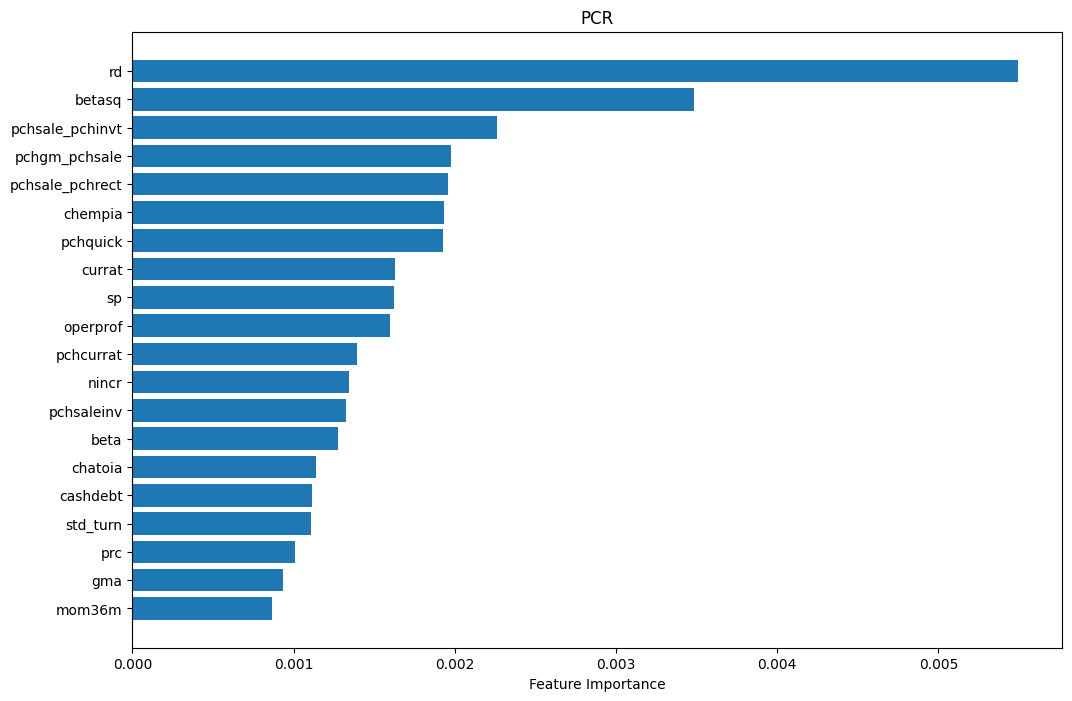

In [26]:
_,f_importance = predict_stock_returns_PCR(x_train, y_train, x_val, y_val)
feature_importance_m = pd.concat([f_importance.to_pandas(),pd.DataFrame(x_train.columns)],axis=1)
feature_importance_m.columns=['val','var']

top20_features = feature_importance_m.sort_values(by='val',ascending=False).head(20)
plt.figure(figsize=(12, 8))
plt.title("PCR")
plt.barh(range(20), top20_features['val'], align="center")
plt.yticks(range(20), top20_features['var'])
plt.gca().invert_yaxis()  # highest importances at the top
plt.xlabel("Feature Importance")
plt.show()

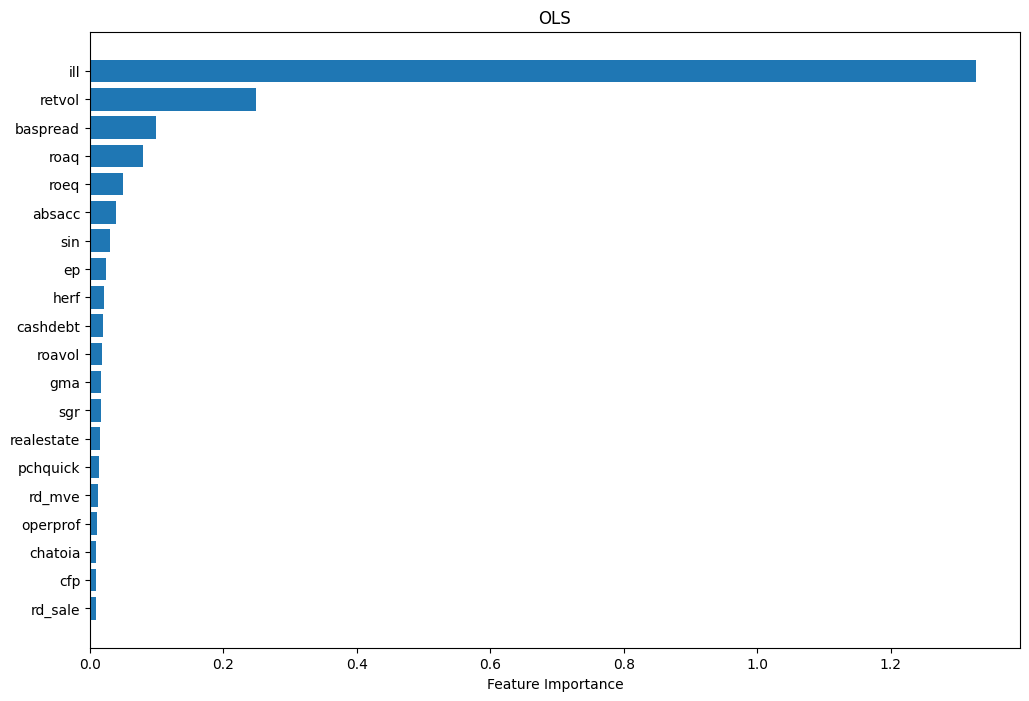

In [27]:
_,f_importance = predict_stock_returns_OLS(x_train, y_train, x_val, y_val)
feature_importance_m = pd.concat([f_importance.to_pandas(),pd.DataFrame(x_train.columns)],axis=1)
feature_importance_m.columns=['val','var']

top20_features = feature_importance_m.sort_values(by='val',ascending=False).head(20)
plt.figure(figsize=(12, 8))
plt.title("OLS")
plt.barh(range(20), top20_features['val'], align="center")
plt.yticks(range(20), top20_features['var'])
plt.gca().invert_yaxis()  # highest importances at the top
plt.xlabel("Feature Importance")
plt.show()

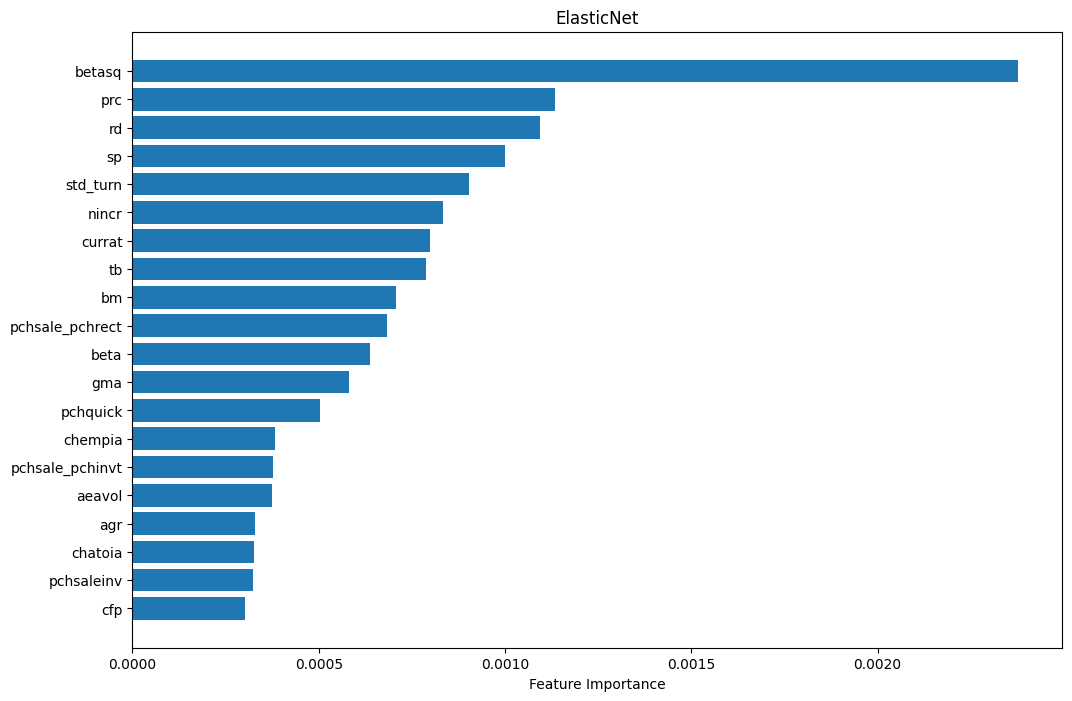

In [28]:
_,f_importance = predict_stock_returns_ElasticNet(x_train, y_train, x_val, y_val, 0.8, 0)
feature_importance_m = pd.concat([f_importance.to_pandas(),pd.DataFrame(x_train.columns)],axis=1)
feature_importance_m.columns=['val','var']

top20_features = feature_importance_m.sort_values(by='val',ascending=False).head(20)
plt.figure(figsize=(12, 8))
plt.title("ElasticNet")
plt.barh(range(20), top20_features['val'], align="center")
plt.yticks(range(20), top20_features['var'])
plt.gca().invert_yaxis()  # highest importances at the top
plt.xlabel("Feature Importance")
plt.show()

## feature importance for monthly macro_data

In [145]:
_,f_importance = predict_stock_returns_PCR(mx_train, my_train, mx_val, my_val, 6)
feature_importance_pcr = pd.concat([f_importance.to_pandas(),pd.DataFrame(mx_train.columns)],axis=1)
feature_importance_pcr.columns=['pcr','var']


_,f_importance = predict_stock_returns_OLS(mx_train, my_train, mx_val, my_val)
feature_importance_ols = pd.concat([f_importance.to_pandas(),pd.DataFrame(mx_train.columns)],axis=1)
feature_importance_ols.columns=['ols','var']

_,f_importance = predict_stock_returns_ElasticNet(mx_train, my_train, mx_val, my_val, 0.8, 0)
feature_importance_elastic = pd.concat([f_importance.to_pandas(),pd.DataFrame(mx_train.columns)],axis=1)
feature_importance_elastic.columns=['elastic','var']


[I] [08:04:09.275815] Unused keyword parameter: n_comp during cuML estimator initialization
[W] [08:04:09.276233] Warning(`fit`): As of v0.16, PCA invoked without an n_components argument defaults to using min(n_samples, n_features) rather than 1


In [178]:
importance_df = feature_importance_pcr.merge(feature_importance_ols,on=['var']).merge(feature_importance_elastic,on=['var'])

In [179]:
df = pd.read_csv("importance_df.csv").rename(columns={'Unnamed: 0':'var'})
importance_df = importance_df.merge(df,on='var')

# bar plot
fig = px.bar(importance_df.set_index('var'))
# define plot layout
fig.update_layout(
    plot_bgcolor='rgba(0,0,0,0)',  # set the background color
    barmode='group',
    yaxis_gridcolor='lightgray',
    yaxis_gridwidth = 1
)

fig.show()

## Monthly Prediction

In [38]:
res_PCR = training_model(data,list(set(data.columns)-set(excep_cols)),'PCR')
print(res_PCR['all'].mean())
print(res_PCR['top'].mean())
print(res_PCR['bottom'].mean())


20161230
R_all   -0.011219
dtype: float64
R_top   -0.03737
dtype: float64
R_bottom    0.032109
dtype: float64


In [34]:
res_Elastic = training_model(data,list(set(data.columns)-set(excep_cols)),'Elastic_Net')
print(res_Elastic['all'].median())
print(res_Elastic['top'].median())
print(res_Elastic['bottom'].median())

20161230
R_all    0.036148
dtype: float64
R_top    0.058414
dtype: float64
R_bottom    0.015724
dtype: float64


In [36]:
feature_cols_OLS3 = ['chmom','indmom','mom1m','mom6m','mom12m','mom36m','mvel1','bm']
res_OLS3 = training_model(data, feature_cols_OLS3, 'OLS')
print(res_OLS3['all'].median())
print(res_OLS3['top'].median())
print(res_OLS3['bottom'].median())

20161230
R_all    0.001525
dtype: float64
R_top    0.001631
dtype: float64
R_bottom    0.001792
dtype: float64


In [37]:
res_OLS3 = training_model(data, list(set(data.columns)-set(excep_cols)), 'OLS')
print(res_OLS3['all'].median())
print(res_OLS3['top'].median())
print(res_OLS3['bottom'].median())

20161230
R_all   -0.033953
dtype: float64
R_top   -0.060734
dtype: float64
R_bottom    0.009397
dtype: float64


## Year Prediction

In [93]:
def training_model_yearly(df,feature_cols, model_name):
  # try:
    # 每年重新拟合模型的步长
    R2_all = pd.DataFrame([0],columns=['R_all'])
    R2_top = pd.DataFrame([0],columns=['R_top'])
    R2_bottom = pd.DataFrame([0],columns=['R_bottom'])
    fit_interval_years = 10

    # 计算每个拟合周期的起始和结束日期
    start_date = df['year'].min()
    end_date = df['year'].max()
    train_end_date = end_date -1
    print(end_date)
    fit_start_date = start_date
    fit_end_date = start_date + fit_interval_years
    res = pd.DataFrame([],columns=['R','char_num'])


    while fit_end_date <= train_end_date:
        # collect train_df
        train_df = df[(df['year'] >= fit_start_date) & (df['year'] < fit_end_date)].fillna(0)
        train_features = train_df[feature_cols].to_cupy()
        train_target = train_df['RET'].to_cupy()
        # collect validation_df
        val_start_date = fit_end_date
        val_end_date = fit_end_date + 8*1e4
        val_df = df[(df['year'] >= val_start_date) & (df['year'] < val_end_date)].fillna(0)
        val_features = val_df[feature_cols].to_cupy()
        val_target = val_df['RET'].to_cupy()

        # Group by 'permno' and compute the mean of 'mvel1' for each stock
        mean_mvel1 = val_df.groupby('permno')['mvel1'].mean()

        # Sort stocks by average 'mvel1' value
        sorted_permnos = mean_mvel1.sort_values(ascending=False)

        # Get the permno values for the top and bottom 1000 stocks
        top_1000_permnos = sorted_permnos.head(1000).index
        bottom_1000_permnos = sorted_permnos.tail(1000).index

        # grouped validation set
        top_val = val_df[val_df['permno'].isin(top_1000_permnos)]
        top_val_x = top_val[feature_cols].to_cupy()
        top_val_y = top_val['RET'].to_cupy()
        bottom_val = val_df[val_df['permno'].isin(bottom_1000_permnos)]
        bottom_val_x = bottom_val[feature_cols].to_cupy()
        bottom_val_y = bottom_val['RET'].to_cupy()

        # train model, validate and collect R2
        if model_name =='Elastic_Net':
            Rsquare_all,_ = predict_stock_returns_ElasticNet(train_features, train_target, val_features,val_target, 0.7, 0)
            Rsquare_top,_ = predict_stock_returns_ElasticNet(train_features, train_target, top_val_x, top_val_y, 0.7, 0.0)
            Rsquare_bottom,_ = predict_stock_returns_ElasticNet(train_features, train_target, bottom_val_x, bottom_val_y, 0.7, 0)

        elif model_name == 'PCR':
            Rsquare_all,_ = predict_stock_returns_PCR(train_features, train_target, val_features, val_target)
            Rsquare_top,_ = predict_stock_returns_PCR(train_features, train_target, top_val_x, top_val_y)
            Rsquare_bottom,_ = predict_stock_returns_PCR(train_features, train_target, bottom_val_x, bottom_val_y)
        elif model_name == 'OLS':
            Rsquare_all,_ = predict_stock_returns_OLS(train_features, train_target, val_features, val_target)
            Rsquare_top,_ = predict_stock_returns_OLS(train_features, train_target, top_val_x, top_val_y)
            Rsquare_bottom,_ = predict_stock_returns_OLS(train_features, train_target, bottom_val_x, bottom_val_y)
        R2_all.loc[fit_end_date,'R_all'] = Rsquare_all
        R2_top.loc[fit_end_date,'R_top'] = Rsquare_top
        R2_bottom.loc[fit_end_date,'R_bottom'] = Rsquare_bottom

        # res.loc[fit_end_date,'char_num'] = max_char_num

        # update the next period
        fit_end_date += 1e4

    return {'all':R2_all, 'top':R2_top, 'bottom':R2_bottom}

In [54]:
res_PCR = training_model_yearly(year_data,list(set(data.columns)-set(excep_cols)),'PCR')
print(res_PCR['all'].mean().abs())
print(res_PCR['top'].mean().abs())
print(res_PCR['bottom'].mean().abs())


2016.0
R_all   -0.055542
dtype: float64
R_top   -0.568969
dtype: float64
R_bottom    0.032734
dtype: float64


In [94]:
res_Elastic = training_model_yearly(year_data,list(set(data.columns)-set(excep_cols)),'Elastic_Net')
print(res_Elastic['all'].median().abs())
print(res_Elastic['top'].median().abs())
print(res_Elastic['bottom'].median().abs())

2016.0
R_all    0.004948
dtype: float64
R_top    0.070003
dtype: float64
R_bottom    0.00821
dtype: float64


In [59]:
feature_cols_OLS3 = ['chmom','indmom','mom1m','mom6m','mom12m','mom36m','mvel1','bm']
res_OLS3 = training_model_yearly(year_data, feature_cols_OLS3, 'OLS')
print(res_OLS3['all'].median().abs())
print(res_OLS3['top'].median().abs())
print(res_OLS3['bottom'].median().abs())

2016.0
R_all    0.133042
dtype: float64
R_top    0.232501
dtype: float64
R_bottom    0.089013
dtype: float64


In [63]:
res_OLS3 = training_model_yearly(year_data, list(set(data.columns)-set(excep_cols)), 'OLS')
print(res_OLS3['all'].median().abs())
print(res_OLS3['top'].median().abs()-1)
print(res_OLS3['bottom'].median().abs())

2016.0
R_all    0.666107
dtype: float64
R_top    0.5295
dtype: float64
R_bottom    0.33274
dtype: float64


##  Replication of 8 Macroeconomic Predictors

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
original_data = pd.read_excel("datashare//PredictorData.xls")

In [ ]:
original_data['IndexDiv']  = original_data['Index'] + original_data['D12']
original_data['dp'] = np.log(original_data['D12']) - np.log(original_data['Index'])
original_data['ep'] = np.log(original_data['E12']) - np.log(original_data['Index'])
original_data['dy'] = np.log(original_data['D12']).shift(1) - np.log(original_data['Index'])
original_data['logret'] = np.log(original_data['Index']).diff()
original_data['logretdiv'] = np.log(original_data['IndexDiv'].shift(1)) - np.log(original_data['Index'])
original_data['logRfree'] = np.log(original_data['Rfree'] + 1)
original_data['rp_div'] = original_data['logretdiv'] - original_data['logRfree']
original_data['dfy'] = original_data['BAA'] - original_data['AAA']
original_data['tms'] = original_data['ltr'] - original_data['tbl']

Text(0.5, 0, 'time')

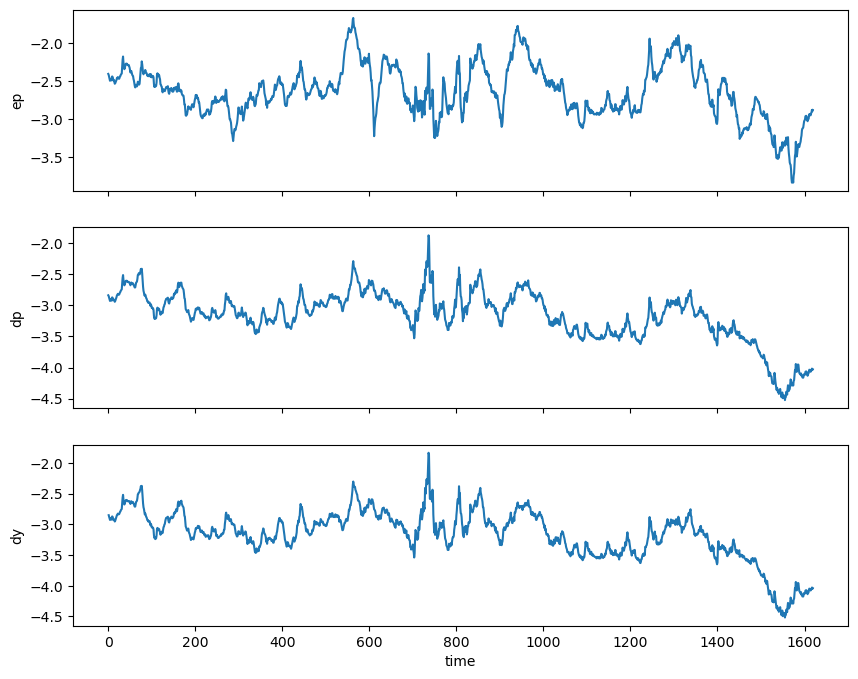

In [ ]:
y1 = original_data['ep']
y2 = original_data['dp']
y3 = original_data['dy']
x = original_data.index
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(10, 8))
ax1.plot(x, y1)
ax1.set_ylabel('ep')
ax2.plot(x, y2)
ax2.set_ylabel('dp')
ax3.plot(x, y3)
ax3.set_ylabel('dy')
ax3.set_xlabel('time')

In [ ]:
original_data[['yyyymm','dp','ep','b/m','ntis','tbl','dfy','tms','svar']].to_csv("MacroeconomicPredictors.csv")